# Dynamic QSP reporting with R and Jupiter

_This is an example of creation of a dynamic QSP report in R and Jupiter build based on heta-compiler and mrgsolve. The content of this file and modeling platform is published in GitHub repository <https://github.com/insysbio/insulin-signaling-t2d>_

## Preamble

The QSP model which is used as an example of QSP model was published in the article:

>Brannmark C, Nyman E, Fagerholm S, Bergenholm L, Ekstrand EM, Cedersund G, Stralfors P. Insulin Signaling in Type 2 Diabetes: Experimental and modeling analyses reveal mechanisms of insulin resistance in human adipocytes. Journal of biological chemistry.. 2013 288(14):9867–9880. DOI: 10.1074/jbc.M112.432062

The SBML code was downloaded from BioModels <https://www.ebi.ac.uk/biomodels/BIOMD0000000448> and used as the part of the [Heta-based](https://hetalang.github.io/#/) modeling platform.

The report includes the steps to reproduce simulations from the original article demonstration facilities of the approach and necessary setups.

All necessary files can also be found in [the repository](https://github.com/insysbio/insulin-signaling-t2d).

## Preparations

For easier creation of the Heta-based platform install [heta compiler](https://hetalang.github.io/#/heta-compiler/?id=installation).

In command line interface (console) run the code below to create heta platform template

```sh
heta init
```
The minimal content will be created.

Download the SBML model [from the database](https://www.ebi.ac.uk/biomodels/BIOMD0000000448) and copy it into `src/BIOMD0000000448.xml`

Update the `src/index.heta` with the following content:

```heta
// load SBML model as a content of the platform
include BIOMD0000000448_url.xml type sbml

// make the records of a model observable
block {output: true} begin
  measuredIRp;
  measuredIRint;
  measuredIRS1p;
  measuredIRS1307;
  measuredPKB308p;
  measuredPKB473p;
  measuredAS160p;
  measuredmTORC1a;
  measuredS6Kp;
  glucoseuptake;
  measuredmTORC2a;
  measuredS6p;
end

// make insulin to be an input of the model
insulin @Const = 10; // nM

// make IR (insuline resistance) specific parameters to be input of the model
IR_total @Const = 100;    // reduce to 55%
GLUT4_total @Const = 100; // GLUT4 reduce to 50%
diabetes @Const = 1;      // reduce to 15%

// recalculate initial values for IR and base conditions
IR .= IR_total * 99.87/100; // 99.87
IRp .= 0;
IRins .= 0;
IRip .= IR_total * 0.02/100;      // 0.02
IRi .= IR_total * 0.11/100;       // 0.11
//
GLUT4 .= GLUT4_total * 73.48/100;   // 73.48
GLUT4m .= GLUT4_total * 26.52/100;  // 26.52

// variable parameters
k1a @Const = 0.6331;
k1basal @Const = 0.03683;
k1c @Const = 0.8768;
k1d @Const = 31.01;

#export { format: Mrgsolve, filepath: _mrgsolve };
```

Install [R](https://www.r-project.org/), [RStudio](https://www.rstudio.com/products/rstudio/) and add all necessary packages:

```r
install.packages('mrgsolve')
install.packages('ggplot2')
```

## Loading platform

In [1]:
library('mrgsolve')
library('ggplot2')
library('dplyr')

Warning message:
"package 'mrgsolve' was built under R version 3.6.3"
Attaching package: 'mrgsolve'

The following object is masked from 'package:stats':

    filter

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



The approach uses __mrgsolve__ package as a simulation engine and __Heta compiler__ is a connector to SBML and Heta formats.
Heta compiler can be run from the R environment. Mind the current working directory and the location of the Heta-based platform: `..`.

In [2]:
system('heta build --dist-dir . ..', intern = TRUE)

[1] "Running compilation with declaration file \"Y:\\PLATFORMS\\insulin-signaling-t2d\\platform.json\"..."                                      
 [2] "\033[info] \033Builder initialized in directory \"Y:\\PLATFORMS\\insulin-signaling-t2d\"."                                         
 [3] "\033[info] \033Platform id: \"template\""                                                                                          
 [4] "\033[info] \033Compilation of module \"src/index.heta\" of type \"heta\"..."                                                       
 [5] "\033[info] \033Reading module of type \"heta\" from file \"Y:\\PLATFORMS\\insulin-signaling-t2d\\src\\index.heta\"..."             
 [6] "\033[info] \033Reading module of type \"sbml\" from file \"Y:\\PLATFORMS\\insulin-signaling-t2d\\src\\BIOMD0000000448_url.xml\"..."
 [7] "\033[info] \033Setting references in elements, total length 170"                                                                   
 [8] "\033[info] \033Checking for circular references in Records."                                                                       
 [9] "\033[warn] \033Units checking skipped. To turn it on set \"unitsCheck: true\" in declaration."                                     
[10] "\033[info] \033Checking unit's terms."                                                                                             
[11] "\033[info] \033Start exporting to files, total: 1."                                                                                
[12] "\033[info] \033Exporting to \"Y:\\PLATFORMS\\insulin-signaling-t2d\\_mrgsolve\" of format \"Mrgsolve\"..."                         
[13] "Compilation OK!"

After compiling model it can be loaded into mrgsolve.

In [3]:
Sys.setenv(PATH = paste('C:\\Rtools\\mingw_64\\bin', Sys.getenv('PATH'), sep=';'))

m <- mrgsolve::mread(model = 'nameless', file = '../_mrgsolve/nameless.cpp')

# list of observables
observables <- paste(
  'measuredIRp',
  'measuredIRint',
  'measuredIRS1p',
  'measuredIRS1307',
  'measuredPKB308p',
  'measuredPKB473p',
  'measuredAS160p',
  'measuredmTORC1a',
  'measuredS6Kp',
  'glucoseuptake',
  'measuredmTORC2a',
  'measuredS6p',
  sep=', '
)

Building nameless ... done.


## Default simulation

To simulate the observables only one line of code is required. Here we are using “chain” with %>% syntax.

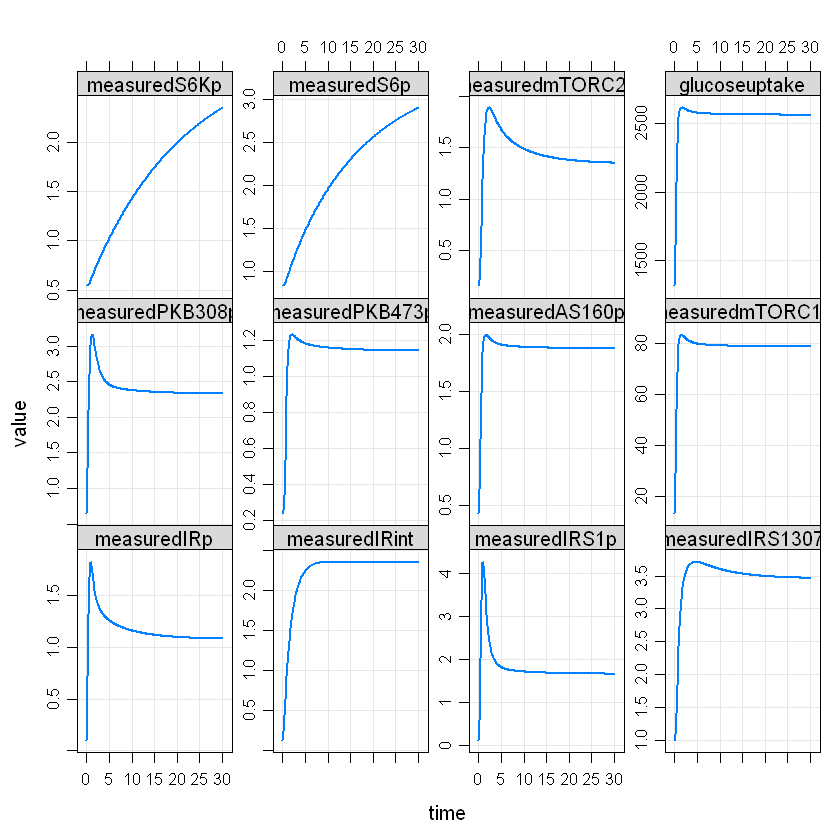

In [4]:
m %>% mrgsim(end = 30, outvars = observables) %>% plot

Based on the original publication the insuline resistance (IR) can be set by updating three parameters.

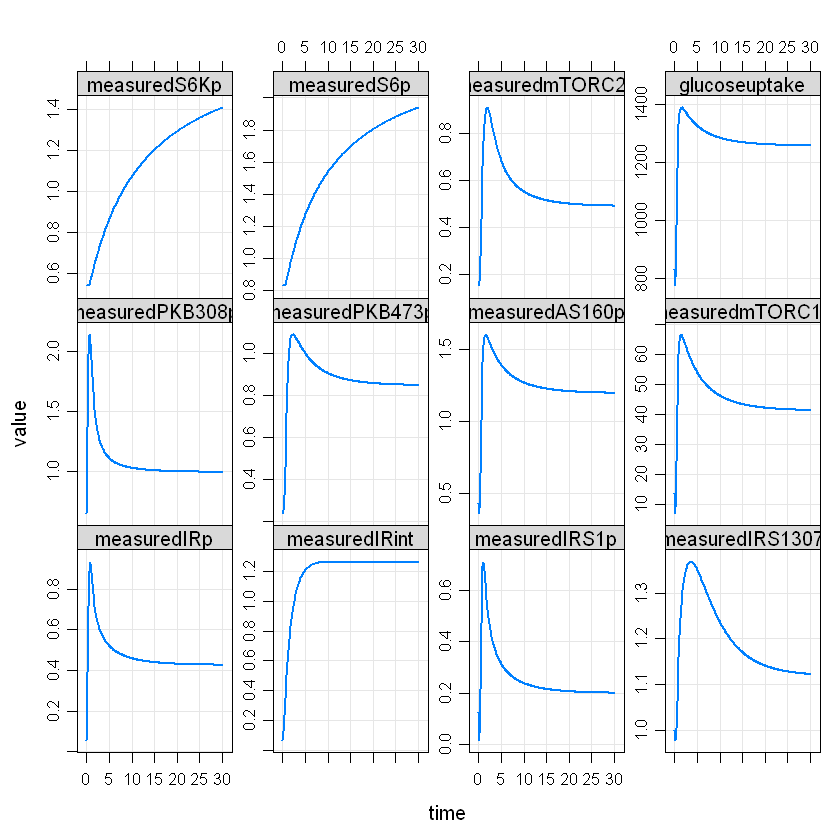

In [5]:
m %>% param(IR_total=55, GLUT4_total=50, diabetes=0.15) %>% mrgsim(end = 30, outvars = observables) %>% plot

## Simulation scenarios

Mrgsolve does not operate with "scenario/condition" terms.
This functionality can be reproduced by `update` function.

In [6]:
scn_base <- m %>% update(end = 30, outvars = observables)
scn_ir <- m %>% param(IR_total=55, GLUT4_total=50, diabetes=0.15) %>% update(end = 30, outvars = observables)

## Advanced visualization

If you need to reshape and visualize different simulation results the easier way is to convert simulation results into `data.frame`.

The following simulations reproduce the figures from the original paper.

In [7]:
results_df_base <- mrgsim(scn_base) %>% as.data.frame
results_df_ir <- mrgsim(scn_ir) %>% as.data.frame


results_df_base$scenario <- 'base'
results_df_ir$scenario <- 'ir'
results_df <- rbind(results_df_base, results_df_ir)
head(results_df)

ID,time,measuredIRp,measuredIRint,measuredIRS1p,measuredIRS1307,measuredPKB308p,measuredPKB473p,measuredAS160p,measuredmTORC1a,measuredS6Kp,measuredS6p,measuredmTORC2a,glucoseuptake,scenario
1,0.0,0.1040440,0.1300000,0.1236214,0.9991251,0.6535535,0.2407230,0.4314513,13.49975,0.5425862,0.8322067,0.1521852,1312.389,base
1,0.1,0.3656183,0.1626192,0.2080825,1.0133725,0.8339305,0.2420081,0.4663869,16.03037,0.5426955,0.8322151,0.1618738,1367.925,base
1,0.2,0.7127218,0.2371987,0.5828224,1.0825199,1.2826638,0.2529724,0.6351150,29.04322,0.5441430,0.8335344,0.2086452,1607.695,base
1,0.3,1.0436642,0.3309626,1.2393722,1.2184954,1.7229465,0.2827919,0.8592656,43.57647,0.5481316,0.8381281,0.2990098,1865.918,base
1,0.4,1.3179444,0.4323480,2.0126654,1.4037934,2.0965966,0.3396150,1.0798411,54.17484,0.5542332,0.8459596,0.4249389,2070.311,base
1,0.5,1.5255239,0.5353418,2.7545811,1.6160387,2.3786361,0.4258523,1.2934722,62.42421,0.5618803,0.8561799,0.5741381,2233.726,base


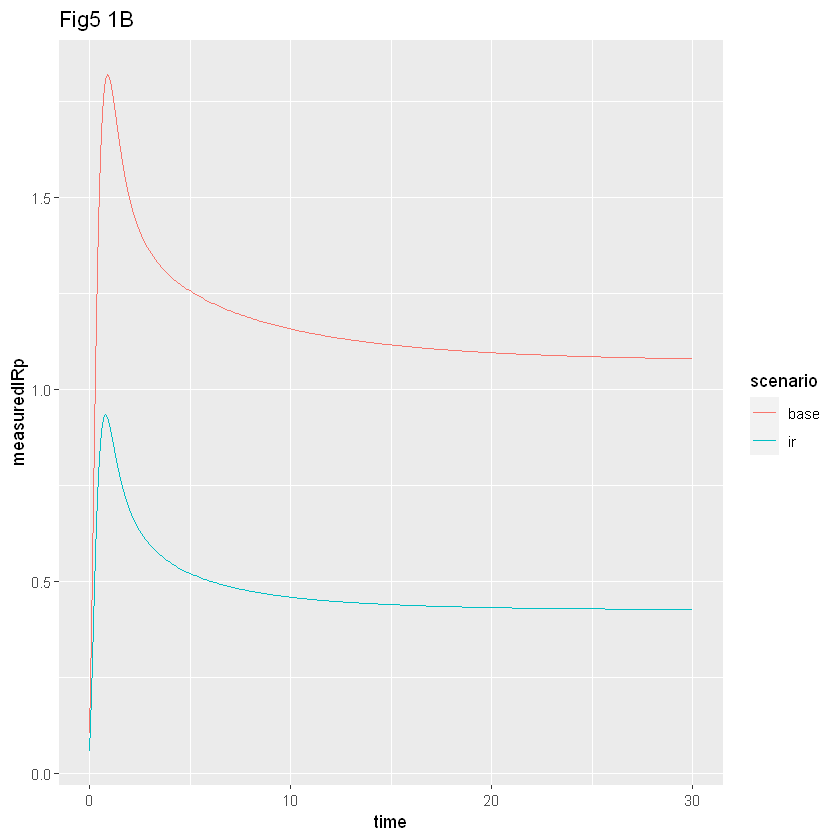

In [8]:
ggplot(results_df, aes(x = time, y = measuredIRp)) +
  geom_line(aes(col = scenario)) +
  labs(title = "Fig5 1B")

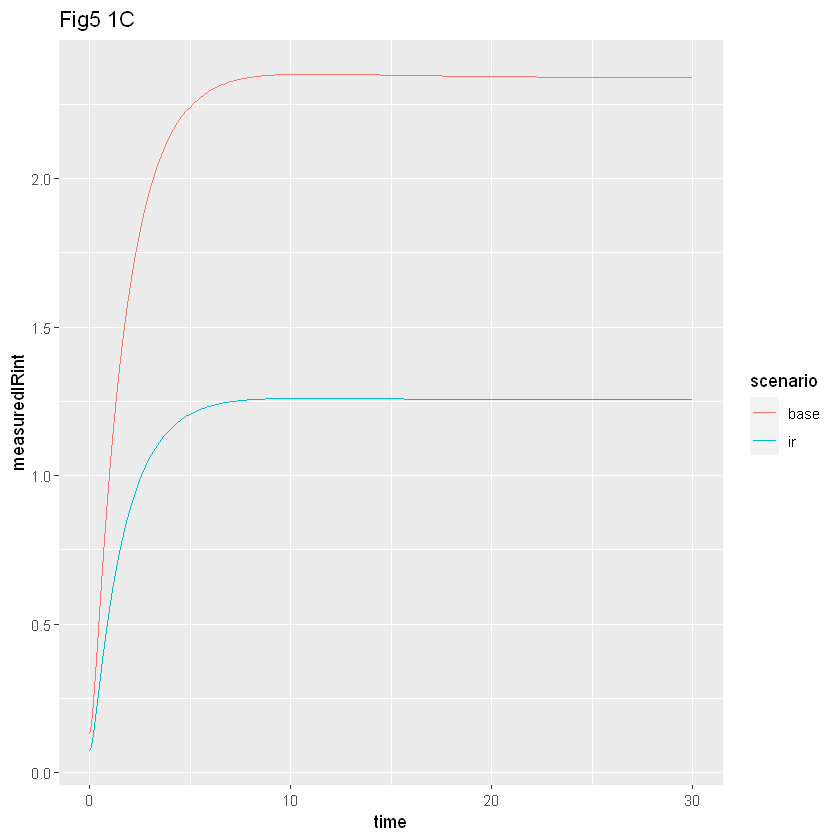

In [9]:
ggplot(results_df, aes(x = time, y = measuredIRint)) +
  geom_line(aes(col = scenario)) +
  labs(title = "Fig5 1C")

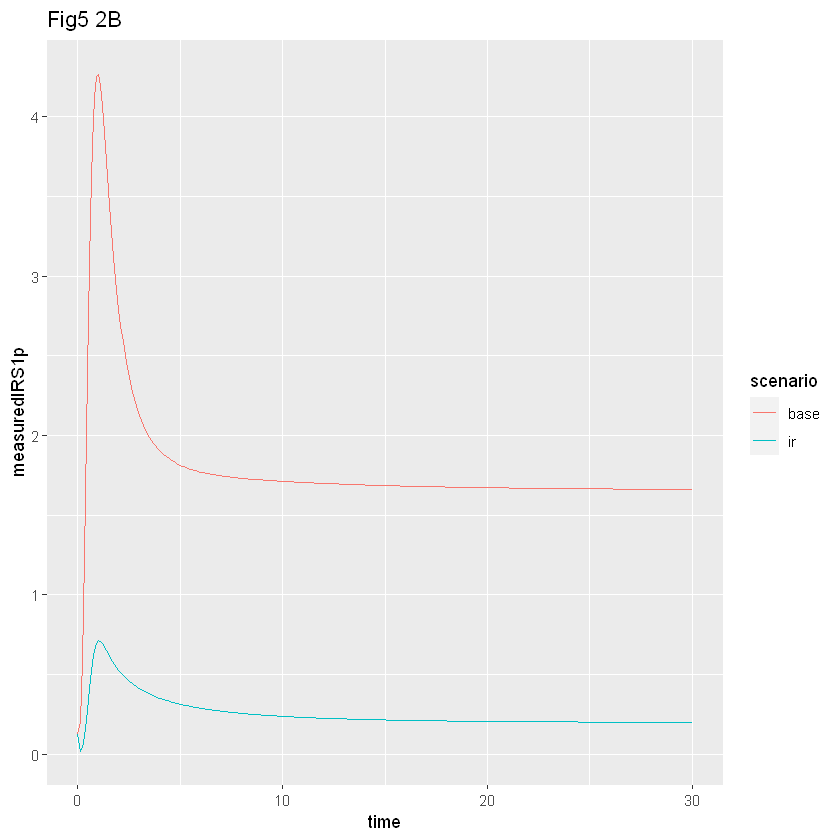

In [10]:
ggplot(results_df, aes(x = time, y = measuredIRS1p)) +
  geom_line(aes(col = scenario)) +
  labs(title = "Fig5 2B")

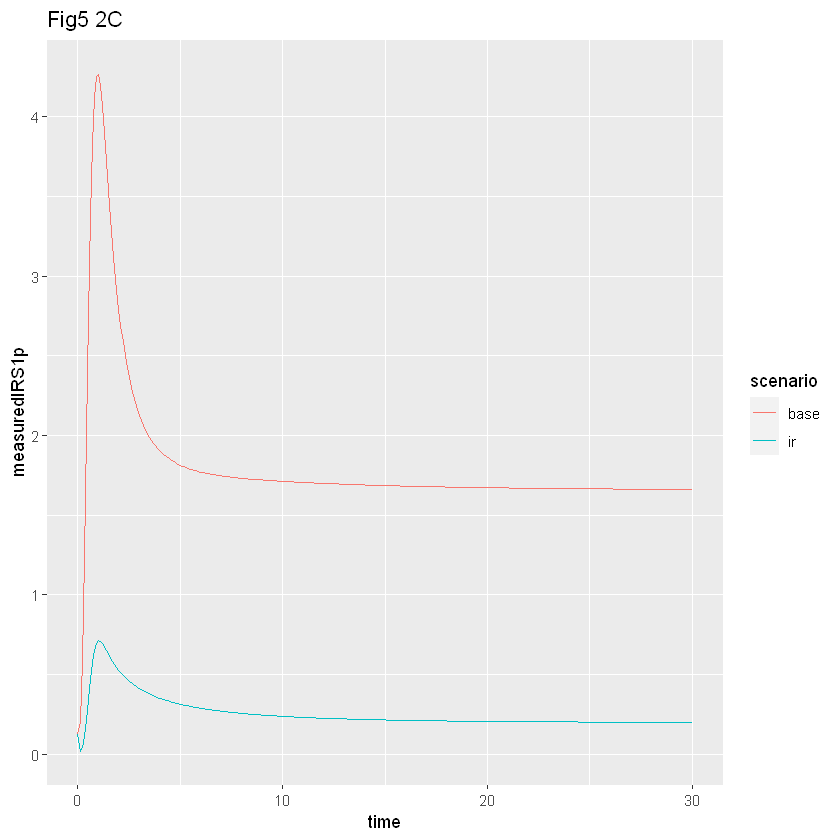

In [11]:
ggplot(results_df, aes(x = time, y = measuredIRS1p)) +
  geom_line(aes(col = scenario)) +
  labs(title = "Fig5 2C")

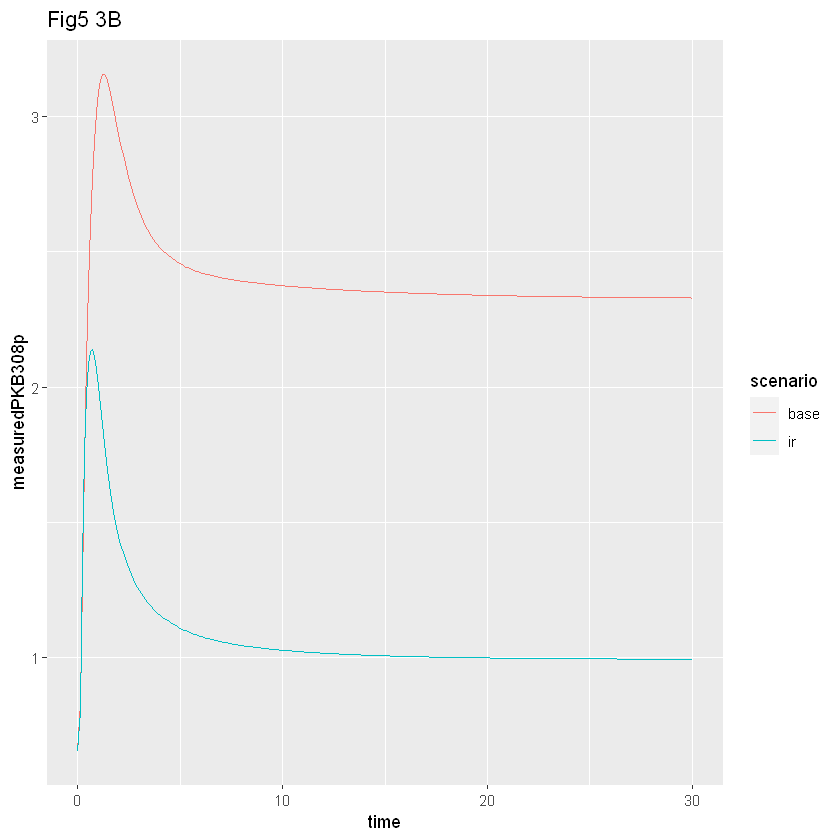

In [12]:
ggplot(results_df, aes(x = time, y = measuredPKB308p)) +
  geom_line(aes(col = scenario)) +
  labs(title = "Fig5 3B")

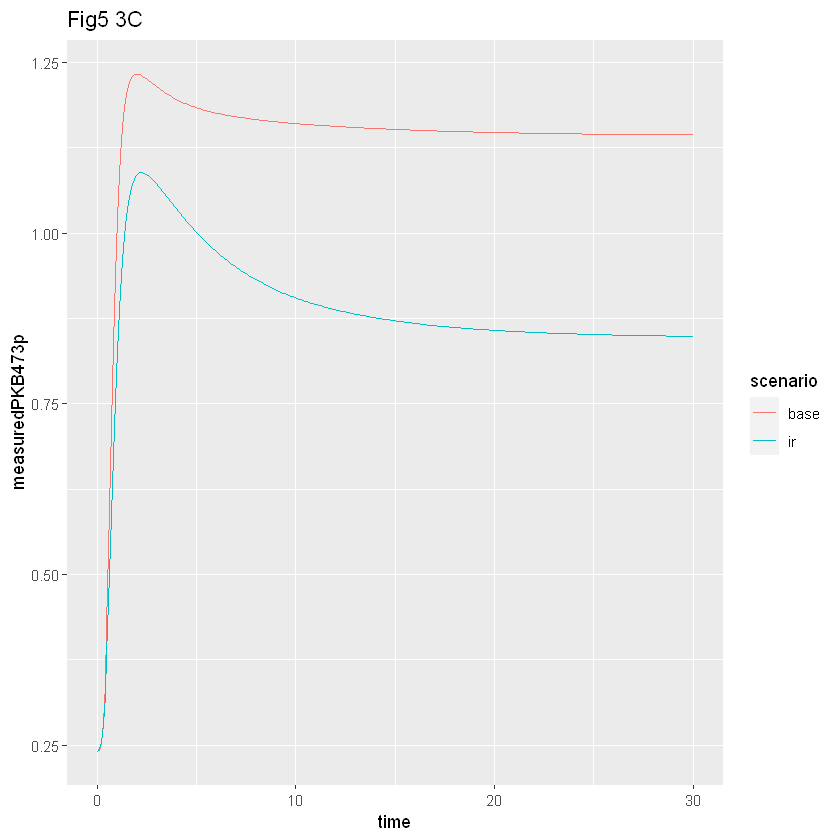

In [13]:
ggplot(results_df, aes(x = time, y = measuredPKB473p)) +
  geom_line(aes(col = scenario)) +
  labs(title = "Fig5 3C")

## Titration-like simulations

The simulations of another type (not time dependence) can be performed and visualized by applying `idata` approach. 
For example in the original article the titration-like experiment is simulated: 
intake of insulin and measurements of different observables after 10 minutes.

To reproduce the figures the following `idata` table should be created:

In [14]:
titr_scn_df <- data.frame(ID = 1:22, insulin=c(
  1.00E-03,
  3.16E-03,
  1.00E-02,
  3.16E-02,
  1.00E-01,
  3.16E-01,
  1.00E+00,
  3.16E+00,
  1.00E+01,
  3.16E+01,
  1.00E+02,
  1.00E-03,
  3.16E-03,
  1.00E-02,
  3.16E-02,
  1.00E-01,
  3.16E-01,
  1.00E+00,
  3.16E+00,
  1.00E+01,
  3.16E+01,
  1.00E+02
))

In [15]:
results_titr_base <- scn_base %>%
  idata_set(titr_scn_df) %>%
  mrgsim(end = 10) %>%
  filter(time == 10)
results_titr_ir <- scn_ir %>%
  idata_set(titr_scn_df) %>%
  mrgsim(end = 10) %>%
  filter(time == 10)

results_titr_base$scenario <- 'base'
results_titr_ir$scenario <- 'ir'
results_titr <- rbind(results_titr_base, results_titr_ir)

results_titr$insulin <- titr_scn_df$insulin[match(results_titr$ID, titr_scn_df$ID)]


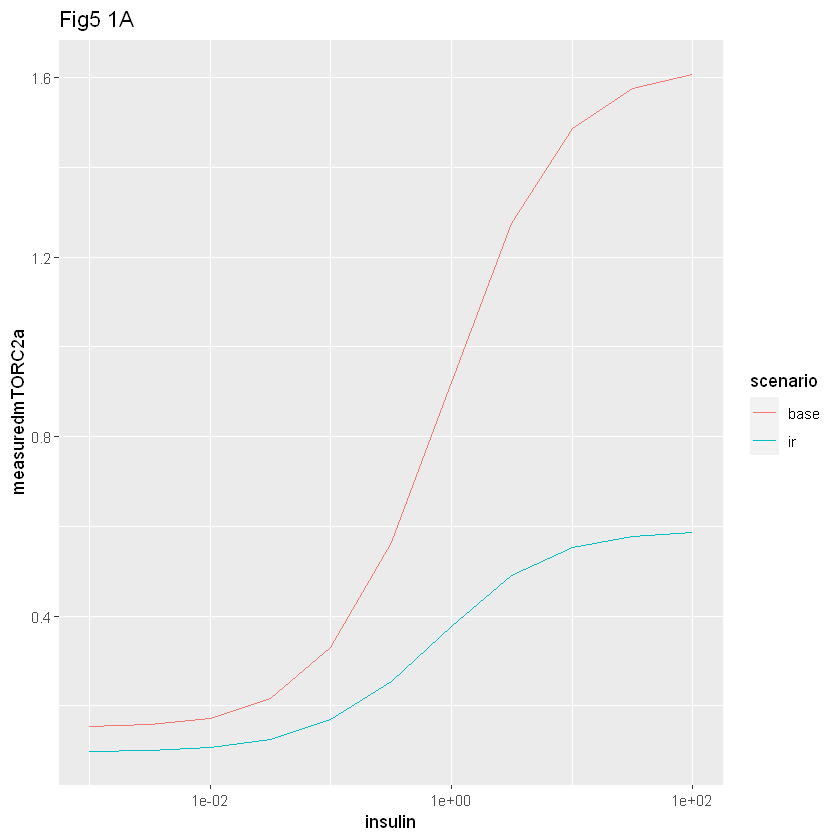

In [16]:
ggplot(results_titr, aes(x=insulin, y=measuredmTORC2a)) +
  geom_line(aes(col=scenario)) +
  scale_x_log10() +
  labs(title="Fig5 1A")

## Multiple simulations

`idata` can also be used to run Monte-Carlo simulations based on parameter variability.
For the demonstration purposes we will generate a random set of parameters: k1a, k1basal, k1c, k1d.
This simulations mimic the uncertainty in the selected parameters.

In [17]:
mc_scn_df <- data.frame(
  ID = 1:100,
  k1a = rlnorm(100, mean = 0.6331, sd = 0.5),
  k1basal = rlnorm(100, mean = 0.03683, sd = 0.5),
  k1c = rlnorm(100, mean = 0.8768, sd = 0.5),
  k1d = rlnorm(100, mean = 31.01, sd = 0.5)
)

In [18]:
results_mc_base <- scn_base %>%
  idata_set(mc_scn_df) %>%
  mrgsim(outvars = 'measuredIRp, measuredIRint')
results_mc_ir <- scn_ir %>%
  idata_set(mc_scn_df) %>%
  mrgsim(outvars = 'measuredIRp, measuredIRint')

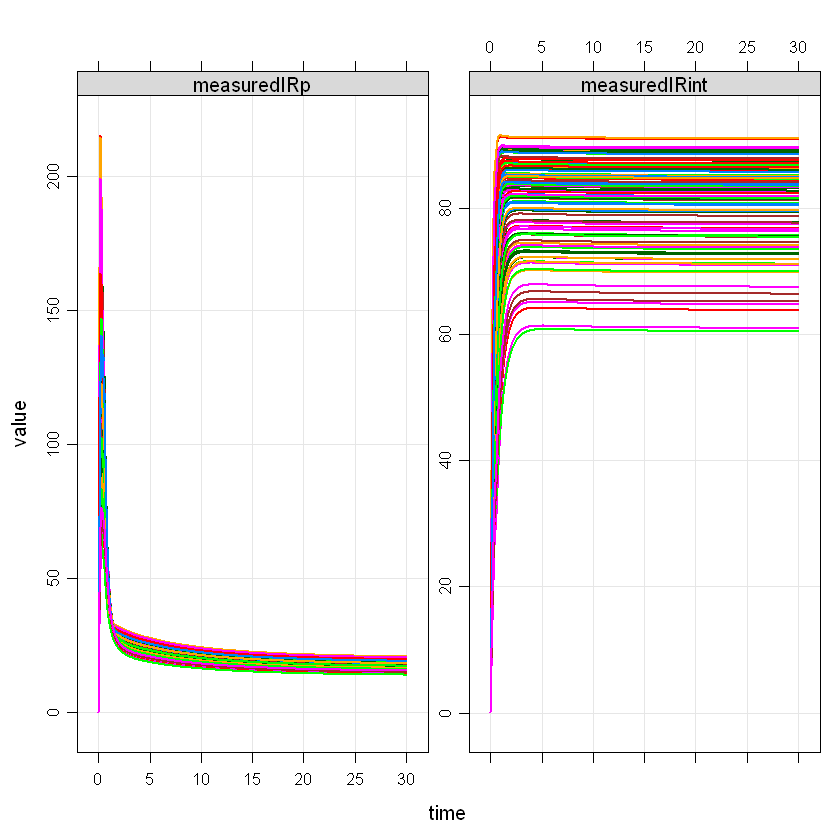

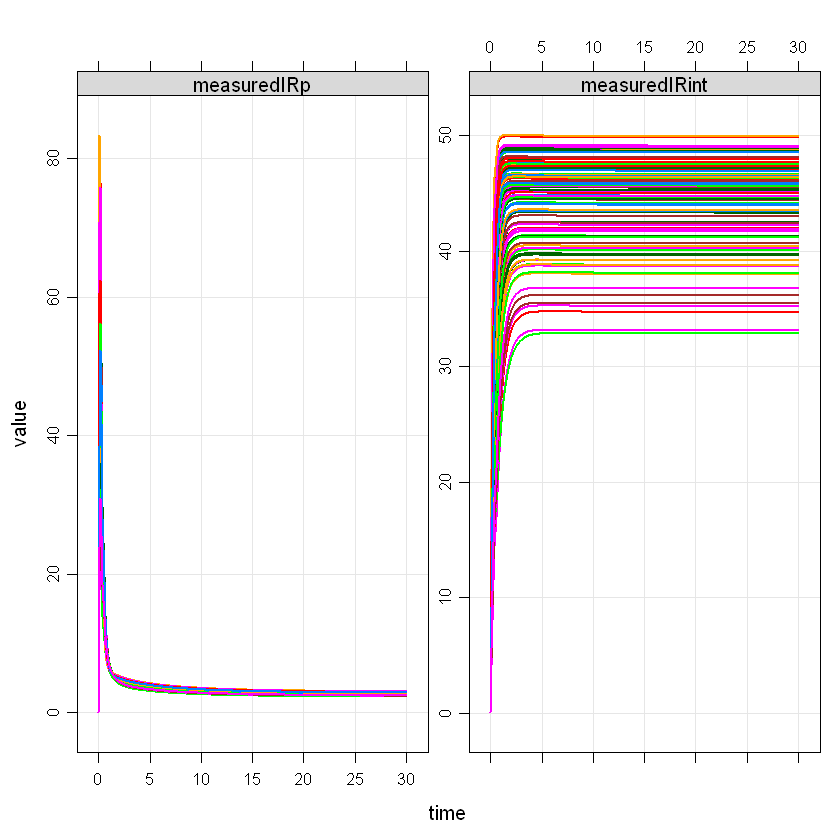

In [19]:
results_mc_base %>% plot
results_mc_ir %>% plot